1. Data import and preparation

We start by importing necessary libraries and loading the data from CSV files. The data is then concatenated into a single DataFrame for further analysis. We also import a module `compute_rv` to compute the run expectancy for each event in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import compute_rv

In [2]:
df = pd.read_csv('2022.csv')

In [3]:
df_all = pd.DataFrame()
for year in range(2015, 2024):
    df_year = pd.read_csv(f'{year}.csv')
    df_all = pd.concat([df_all, df_year])

In [4]:

df = compute_rv.compute_re24(df)
df_all = compute_rv.compute_re24(df_all)
df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,runner_1b,runner_2b,runner_3b,runners,half_inning,bat_score_min,runs_scored_inning_total,runs_scored_rest_of_inning,re24,re24_change
0,4686,FF,2022-08-20,96.9,-1.13,6.48,"Bradish, Kyle",624414,680694,field_out,...,0,0,0,000,661043 1 Top,0,0,0,0.47,-0.24
1,4616,FF,2022-08-20,96.1,-1.46,6.37,"Bradish, Kyle",657077,680694,NaN,...,0,0,0,000,661043 1 Top,0,0,0,0.23,0.00
2,4392,FF,2022-08-20,95.4,-1.04,6.72,"Bradish, Kyle",657077,680694,NaN,...,0,0,0,000,661043 1 Top,0,0,0,0.23,0.00
3,4322,CU,2022-08-20,86.1,-1.28,6.52,"Bradish, Kyle",657077,680694,NaN,...,0,0,0,000,661043 1 Top,0,0,0,0.23,0.00
4,4102,FF,2022-08-20,96.6,-1.28,6.44,"Bradish, Kyle",657077,680694,field_out,...,0,0,0,000,661043 1 Top,0,0,0,0.23,-0.14


In [5]:
df.groupby('events')['re24_change'].mean()

events
catcher_interf                0.342069
caught_stealing_2b                 NaN
caught_stealing_3b                 NaN
caught_stealing_home               NaN
double                        0.760359
double_play                  -1.060588
field_error                   0.389433
field_out                    -0.239061
fielders_choice               0.699394
fielders_choice_out          -0.702651
force_out                    -0.343922
grounded_into_double_play    -0.898610
hit_by_pitch                  0.350845
home_run                      1.384455
other_out                          NaN
pickoff_1b                         NaN
pickoff_caught_stealing_2b         NaN
sac_bunt                     -0.037797
sac_fly                      -0.072776
sac_fly_double_play          -1.190000
single                        0.454091
strikeout                    -0.279586
strikeout_double_play        -0.911667
triple                        0.987745
triple_play                        NaN
walk              

2. Data transformations

Next, we categorize the events into 'ground_out_events' and 'air_out_events' based on the descriptions provided in the 'des' column. We then create a new column 'new_events' to store these new event categories. Events that do not fall into these categories are labeled as 'other'.

In [6]:
df_all['des'] = df_all['des'].fillna('')
ground_out_events = ['grounded_into_double_play', 'field_out', 'fielders_choice_out', 'force_out']
air_out_events = ['sac_fly', 'sac_fly_double_play', 'field_out', 'double_play', 'fielders_choice_out']

df_all['new_events'] = df_all['events']

df_all.loc[df_all['events'].isin(ground_out_events) & df_all['des'].str.contains('ground'), 'new_events'] = 'ground_out'
df_all.loc[df_all['events'].isin(air_out_events) & ~df_all['des'].str.contains('ground'), 'new_events'] = 'air_out'

allowed_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'ground_out', 'air_out', 'field_error']
df_all.loc[~df_all['new_events'].isin(allowed_events), 'new_events'] = 'other'


In [7]:
ground_out_events = df_all[df_all['new_events'] == 'ground_out']['events'].value_counts()
air_out_events = df_all[df_all['new_events'] == 'air_out']['events'].value_counts()
print("Ground Out Events:\n", ground_out_events)
print("\nAir Out Events:\n", air_out_events)


Ground Out Events:
 field_out                    220547
force_out                     24329
grounded_into_double_play     23870
fielders_choice_out               7
Name: events, dtype: int64

Air Out Events:
 field_out              270757
sac_fly                  7823
double_play              2626
fielders_choice_out      1978
sac_fly_double_play       119
Name: events, dtype: int64


3. Data analysis

We calculate the mean run values for each event and assign these values to a new column 'mean_run_value'. We also calculate the standard deviation of the run values for each event. We then display the top 25 players with the highest mean run values.

In [8]:
mean_run_values = df.groupby('events')['re24_change'].mean()
df['mean_run_value'] = df['events'].map(mean_run_values)


In [9]:
mean_run_values = df_all.groupby('events')['re24_change'].mean()
df_all['mean_run_value'] = df_all['events'].map(mean_run_values)

In [10]:
df.groupby('events')['mean_run_value'].agg(['mean', 'std'])

,mean,std
events,,
catcher_interf,0.342069,0.0
caught_stealing_2b,NaN,NaN
caught_stealing_3b,NaN,NaN
caught_stealing_home,NaN,NaN
double,0.760359,0.0
double_play,-1.060588,0.0
field_error,0.389433,0.0
field_out,-0.239061,0.0
fielders_choice,0.699394,0.0


4. Run value leader deep dive (Context neutral)

2022 run value leaders:

In [11]:
df.groupby(['player_name', 'pitcher'])['mean_run_value'].sum().sort_values().head(25)

player_name        pitcher
Gallen, Zac        668678    -31.402912
Javier, Cristian   664299    -19.070643
Bieber, Shane      669456    -19.036858
Cortes, Nestor     641482    -17.996090
deGrom, Jacob      594798    -17.792064
Ohtani, Shohei     660271    -17.654330
McKenzie, Triston  663474    -17.067427
Rasmussen, Drew    656876    -15.528862
Manoah, Alek       666201    -15.029713
Verlander, Justin  434378    -14.877689
Quantrill, Cal     615698    -14.556892
Scherzer, Max      453286    -14.479975
Anderson, Tyler    542881    -14.456885
Urías, Julio       628711    -14.302883
Luzardo, Jesús     666200    -13.919930
Darvish, Yu        506433    -13.849384
Cease, Dylan       656302    -13.805623
Rodón, Carlos      607074    -12.851758
Burnes, Corbin     669203    -12.454119
Quintana, José     500779    -12.415512
Alcantara, Sandy   645261    -12.004972
Germán, Domingo    593334    -11.842132
Strider, Spencer   675911    -11.820895
Bradish, Kyle      680694    -11.458682
Woodruff, Bra

In [12]:
df_gdp = df[df['events'] == 'grounded_into_double_play']
df_gdp_count = df_gdp.groupby(['player_name', 'pitcher']).size().reset_index(name='gdp_count')
df_new = pd.merge(df_all, df_gdp_count, on=['player_name', 'pitcher'], how='left')
df_new['gdp_count'] = df_new['gdp_count'].fillna(0)



2015-2023 re24 run value leaders:

In [13]:
df_new.groupby(['player_name', 'pitcher'])['mean_run_value'].sum().sort_values().head(20)

player_name         pitcher
deGrom, Jacob       594798    -267.958387
Scherzer, Max       453286    -266.545397
Kershaw, Clayton    477132    -265.666864
Verlander, Justin   434378    -231.166617
Cole, Gerrit        543037    -214.263961
Greinke, Zack       425844    -174.221772
Nola, Aaron         605400    -161.080625
Sale, Chris         519242    -150.730825
Kluber, Corey       446372    -143.978792
Strasburg, Stephen  544931    -142.675262
Wheeler, Zack       554430    -139.375905
Stroman, Marcus     573186    -131.125010
Hendricks, Kyle     543294    -125.988830
Snell, Blake        605483    -121.669283
Buehler, Walker     621111    -116.379497
Castillo, Luis      622491    -115.435368
Morton, Charlie     450203    -115.208680
Jansen, Kenley      445276    -113.518607
Darvish, Yu         506433    -113.051203
Gray, Sonny         543243    -111.638609
Name: mean_run_value, dtype: float64

In [14]:
df_all.groupby(['player_name', 'pitcher'])['re24_change'].sum().sort_values().head(25)

player_name         pitcher
Bautista, Félix     642585    -5.09
Hinojosa, Dalier    648737    -3.44
Suarez, Robert      663158    -3.21
Maddox, Austin      545348    -3.00
Frías, Carlos       516910    -2.77
Cosgrove, Tom       676680    -2.50
Barrios, Yhonathan  553872    -2.30
Felipe, Angel       665734    -2.23
McGee, Easton       668834    -2.20
Martín, Rafael      514669    -2.05
Baz, Shane          669358    -1.87
Abbott, Andrew      671096    -1.86
Vásquez, Randy      681190    -1.78
Morrow, Brandon     453344    -1.71
Castillo, Luis      622379    -1.55
Hancock, Justin     606995    -1.45
Eades, Ryan         592280    -1.40
Aguilar, Miguel     620396    -1.34
De Jesus, Angel     669804    -1.28
Rodriguez, Elvin    660730    -1.23
Neuse, Sheldon      641914    -1.21
Mejia, Jenrry       516769    -1.19
Gose, Anthony       543238    -1.13
Gamboa, Eddie       543195    -1.12
Griffin, Foster     656492    -1.10
Name: re24_change, dtype: float64

5. Model training|

We use the K-Nearest Neighbors algorithm to predict the mean run value based on the launch speed and launch angle of the ball. We split the data into training and testing sets, train the model on the training set, and then evaluate its performance on the testing set using the mean squared error and R2 score. Number of neighbors parameter was tested from 100 up to 5000 with no discernible loss in MSE or R squared using 5000 neighbors.

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
df_all_bip = df_all.dropna(subset=['launch_speed', 'launch_angle', 'mean_run_value'])

X = df_all_bip[['launch_speed', 'launch_angle']]
y = df_all_bip['mean_run_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=5000, n_jobs=-1)
knn.fit(X_train, y_train)

joblib.dump(knn, 'knn_rv.joblib')

# knn_rv = joblib.load('knn_rv.joblib')

['knn_rv.joblib']

In [16]:
knn_rv = joblib.load('knn_rv.joblib')

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = knn_rv.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('R2 score: %.2f' % r2_score(y_test, y_pred))


Mean squared error: 0.14
R2 score: 0.42


Impute run value of non-batted ball events like walks and strikeouts

In [18]:
df['pred_run_value'] = np.nan
mask = df[['launch_speed', 'launch_angle']].notna().all(axis=1)
df.loc[mask, 'pred_run_value'] = knn_rv.predict(df.loc[mask, ['launch_speed', 'launch_angle']])

events_to_update = ['walk', 'hit_by_pitch', 'strikeout', 'strikeout_double_play']

mean_run_values_df = df.groupby('events')['re24_change'].mean().to_dict()
mean_run_values_df_all = df_all.groupby('events')['re24_change'].mean().to_dict()

for event in events_to_update:
    mask = (df['events'] == event)
    df.loc[mask, 'pred_run_value'] = mean_run_values_df[event]
    
    mask_all = (df_all['events'] == event)
    df_all.loc[mask_all, 'pred_run_value'] = mean_run_values_df_all[event]


#### 2021 predictive run value leaders:

In [19]:
df_all.loc[df_all['game_year'] == 2021].groupby(['player_name', 'pitcher'])['pred_run_value'].sum().sort_values().head(20)

player_name        pitcher
Cole, Gerrit       543037    -55.846640
Wheeler, Zack      554430    -54.755243
Burnes, Corbin     669203    -54.130039
Scherzer, Max      453286    -53.777859
Ray, Robbie        592662    -53.118391
Nola, Aaron        605400    -48.701068
Gausman, Kevin     592332    -48.061665
Woodruff, Brandon  605540    -44.898865
Eovaldi, Nathan    543135    -42.953624
Buehler, Walker    621111    -42.777006
Urías, Julio       628711    -42.320958
Giolito, Lucas     608337    -40.988198
Berríos, José      621244    -40.615756
Darvish, Yu        506433    -40.594983
Montas, Frankie    593423    -40.175372
Cease, Dylan       656302    -40.069049
Manaea, Sean       640455    -39.458452
Rodón, Carlos      607074    -39.121828
Alcantara, Sandy   645261    -38.906769
Morton, Charlie    450203    -37.974745
Name: pred_run_value, dtype: float64

#### 2022 predictive run value leaders:

In [20]:
df.groupby(['player_name', 'pitcher'])['pred_run_value'].sum().sort_values().head(10)

player_name        pitcher
Alcantara, Sandy   645261    -29.044393
Gallen, Zac        668678    -28.842998
Javier, Cristian   664299    -27.515299
Rasmussen, Drew    656876    -27.106316
deGrom, Jacob      594798    -26.908653
Scherzer, Max      453286    -26.795007
Snell, Blake       605483    -25.220220
Strider, Spencer   675911    -24.937120
Verlander, Justin  434378    -24.852243
Gausman, Kevin     592332    -24.543467
Name: pred_run_value, dtype: float64

#### 2023 predictive run value leaders:

In [21]:
df_all.loc[df_all['game_year'] == 2023].groupby(['player_name', 'pitcher'])['pred_run_value'].sum().sort_values().head(10)

player_name       pitcher
Strider, Spencer  675911    -45.406122
Gausman, Kevin    592332    -39.185837
Ryan, Joe         657746    -34.112166
López, Pablo      641154    -33.794628
Gallen, Zac       668678    -32.720674
Webb, Logan       657277    -32.541990
Wheeler, Zack     554430    -31.703642
Cole, Gerrit      543037    -31.406847
Castillo, Luis    622491    -31.348793
Luzardo, Jesús    666200    -29.588446
Name: pred_run_value, dtype: float64

#### 2021-2023 predictive run value leaders

In [22]:
df_all.loc[df_all['game_year'].isin([2021, 2022, 2023])].groupby(['player_name', 'pitcher'])['pred_run_value'].sum().sort_values().head(10)

player_name     pitcher
Gausman, Kevin  592332    -106.126659
Cole, Gerrit    543037    -103.843543
Scherzer, Max   453286     -94.547499
Wheeler, Zack   554430     -94.401002
Nola, Aaron     605400     -93.482620
Burnes, Corbin  669203     -90.587130
Lynn, Lance     458681     -78.217970
Castillo, Luis  622491     -76.969540
Darvish, Yu     506433     -76.176460
Gallen, Zac     668678     -75.208302
Name: pred_run_value, dtype: float64

Acquire innings pitched and other data from baseball-reference:

In [23]:
from pybaseball import pitching_stats_bref

pitchers_2023 = pitching_stats_bref(2023)
pitchers_2023 = pitchers_2023.loc[:, ['Tm', 'IP', 'ER', 'ERA', 'GDP', 'BB', 'SO', 'BF', 'mlbID']]
pitchers_2023['mlbID'] = pitchers_2023['mlbID'].astype('int64')
pitchers_2023.head()


,Tm,IP,ER,ERA,GDP,BB,SO,BF,mlbID
1,Colorado,6.1,3,4.26,2,3,2,32,472551
2,Cincinnati,81.1,27,2.99,3,27,88,327,671096
3,Washington,26.2,15,5.06,4,15,24,121,676265
4,New York,51.0,27,4.76,3,30,54,228,656061
5,Houston,56.0,14,2.25,4,26,81,231,650556


Get cumulative predictive run value for 2023 pitchers

In [24]:
leaders_23 = df_all \
    .loc[df_all['game_year'] == 2023] \
    .groupby(['player_name', 'pitcher'], as_index=False)['pred_run_value'] \
    .sum() \
    .sort_values(by='pred_run_value') \
    .round(1)

In [25]:
df_23 = pd.merge(leaders_23, pitchers_2023, left_on='pitcher', right_on='mlbID')
df_23.head()

,player_name,pitcher,pred_run_value,Tm,IP,ER,ERA,GDP,BB,SO,BF,mlbID
0,"Strider, Spencer",675911,-45.4,Atlanta,139.1,58,3.75,5,45,217,572,675911
1,"Gausman, Kevin",592332,-39.2,Toronto,144.1,52,3.24,7,37,187,590,592332
2,"Ryan, Joe",657746,-34.1,Minnesota,126.0,62,4.43,5,25,152,523,657746
3,"López, Pablo",641154,-33.8,Minnesota,147.2,60,3.66,6,37,180,600,641154
4,"Gallen, Zac",668678,-32.7,Arizona,155.2,56,3.24,13,32,165,620,668678


In [26]:
df_23['xRV/BF'] = df_23['pred_run_value'].div(df_23['BF']).round(3)

In [27]:
df_23.loc[df_23['IP'] > 100].sort_values(by='xRV/BF').head(20)

,player_name,pitcher,pred_run_value,Tm,IP,ER,ERA,GDP,BB,SO,BF,mlbID,xRV/BF
0,"Strider, Spencer",675911,-45.4,Atlanta,139.1,58,3.75,5,45,217,572,675911,-0.079
1,"Gausman, Kevin",592332,-39.2,Toronto,144.1,52,3.24,7,37,187,590,592332,-0.066
2,"Ryan, Joe",657746,-34.1,Minnesota,126.0,62,4.43,5,25,152,523,657746,-0.065
10,"Eflin, Zach",621107,-29.4,Tampa Bay,132.1,54,3.67,9,18,132,524,621107,-0.056
3,"López, Pablo",641154,-33.8,Minnesota,147.2,60,3.66,6,37,180,600,641154,-0.056
4,"Gallen, Zac",668678,-32.7,Arizona,155.2,56,3.24,13,32,165,620,668678,-0.053
6,"Wheeler, Zack",554430,-31.7,Philadelphia,144.0,58,3.63,4,29,160,596,554430,-0.053
8,"Castillo, Luis",622491,-31.3,Seattle,150.1,54,3.23,2,37,166,607,622491,-0.052
28,"Kershaw, Clayton",477132,-21.8,Los Angeles,105.1,29,2.48,12,26,111,416,477132,-0.052
17,"Garrett, Braxton",666129,-26.2,Miami,122.0,53,3.91,10,21,126,507,666129,-0.052


<AxesSubplot: >

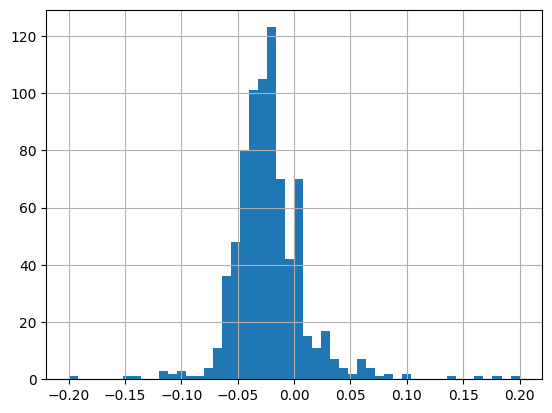

In [28]:
df_23['xRV/BF'].hist(bins=50)

<AxesSubplot: >

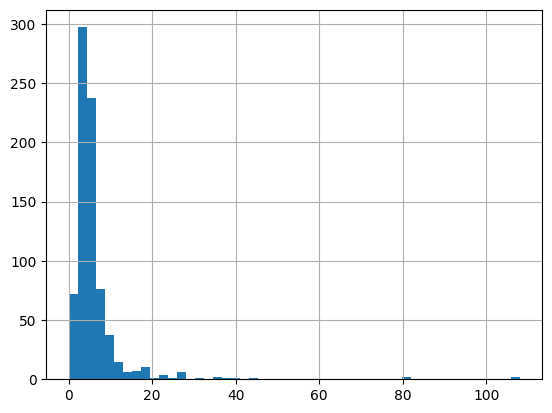

In [29]:
df_23['ERA'].hist(bins=50)

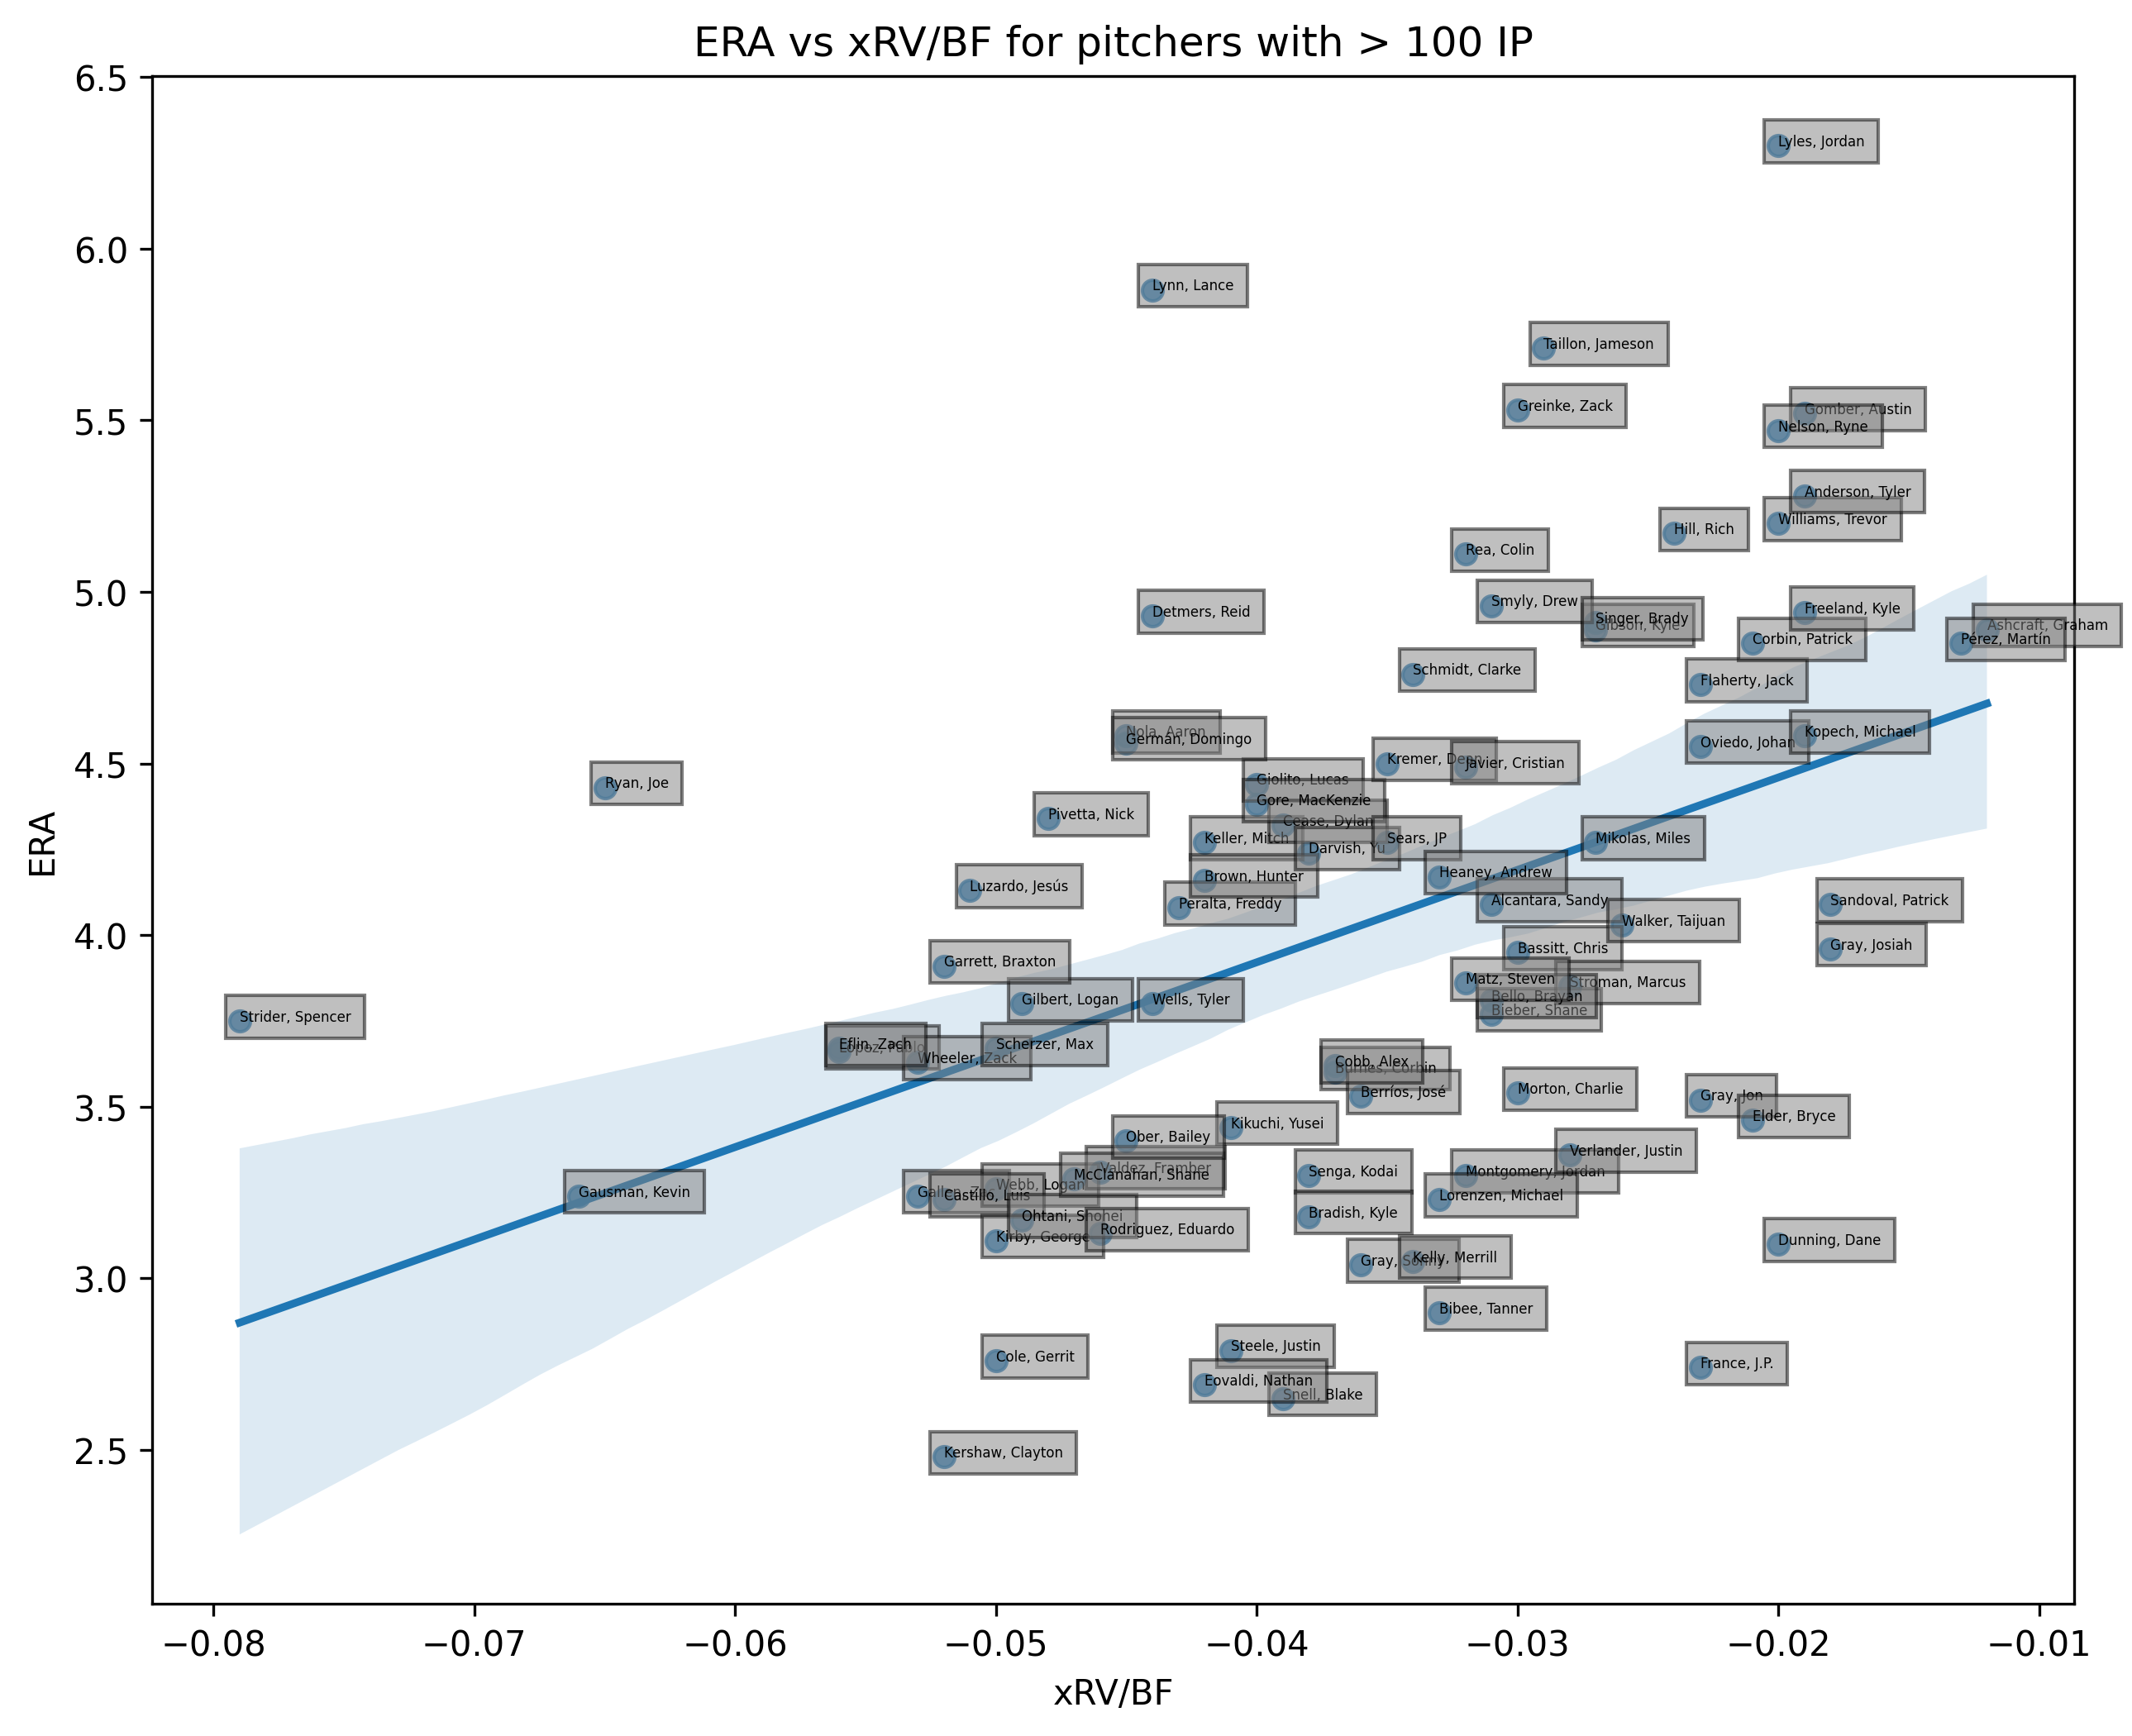

In [30]:

df_100 = df_23[df_23['IP'] > 100]

plt.figure(figsize=(10, 8), dpi=300)
sns.regplot(x='xRV/BF', y='ERA', data=df_100)

for i in range(df_100.shape[0]):
    plt.text(x=df_100['xRV/BF'].iloc[i],
     y=df_100['ERA'].iloc[i],
      s=df_100['player_name'].iloc[i],
       fontdict=dict(color='black',size=4),
        bbox=dict(facecolor='gray',alpha=0.5))

plt.xlabel('xRV/BF')
plt.ylabel('ERA')
plt.title('ERA vs xRV/BF for pitchers with > 100 IP')
plt.show()




In [31]:
import plotly.express as px

df_100 = df_23[df_23['IP'] > 20]

fig = px.scatter(df_100, x='xRV/BF', y='ERA', trendline='ols', hover_name='player_name', hover_data=['IP', 'ERA', 'xRV/BF'])

fig.update_layout(
    title='ERA vs xRV/BF for pitchers with > 100 IP',
    xaxis_title='xRV/BF',
    yaxis_title='ERA'
)

fig.show()

In [32]:
from pybaseball import pitching_stats

xERA_data_2023 = pitching_stats(2022, 2023)
xERA_data_2023.head()


,IDfg


In [33]:
df_all.loc[df_all['events'] == 'walk', 'estimated_woba_using_speedangle'] = 0.7
df_all.loc[df_all['events'] == 'intentional_walk', 'estimated_woba_using_speedangle'] = 0.7
df_all.loc[df_all['events'] == 'hit_by_pitch', 'estimated_woba_using_speedangle'] = 0.7
df_all.loc[df_all['events'] == 'strikeout', 'estimated_woba_using_speedangle'] = 0
df_all.loc[df_all['events'] == 'strikeout_double_play', 'estimated_woba_using_speedangle'] = 0


In [34]:
xera = df_all.loc[df_all['game_year']==2023].groupby(['player_name', 'pitcher'], as_index=False)['estimated_woba_using_speedangle'].mean()

In [35]:
xera

,player_name,pitcher,estimated_woba_using_speedangle
0,"Abad, Fernando",472551,0.433188
1,"Abbott, Andrew",671096,0.294709
2,"Abbott, Cory",676265,0.332777
3,"Abreu, Albert",656061,0.316668
4,"Abreu, Bryan",650556,0.269132
...,...,...,...
774,"Zastryzny, Rob",642239,0.337580
775,"Zerpa, Angel",672582,0.497500
776,"Zimmermann, Bruce",669145,0.321558
777,"Zuñiga, Guillermo",670871,0.371333


In [36]:
er_per_ip_23 = 15442/32175

In [37]:
xwoba_mean = xera['estimated_woba_using_speedangle'].mean()

In [38]:
xera['xERA'] = round(9 * (er_per_ip_23 * ((xera['estimated_woba_using_speedangle'].div(0.321))**2)), 2)

In [39]:
xera

,player_name,pitcher,estimated_woba_using_speedangle,xERA
0,"Abad, Fernando",472551,0.433188,7.87
1,"Abbott, Andrew",671096,0.294709,3.64
2,"Abbott, Cory",676265,0.332777,4.64
3,"Abreu, Albert",656061,0.316668,4.20
4,"Abreu, Bryan",650556,0.269132,3.04
...,...,...,...,...
774,"Zastryzny, Rob",642239,0.337580,4.78
775,"Zerpa, Angel",672582,0.497500,10.38
776,"Zimmermann, Bruce",669145,0.321558,4.33
777,"Zuñiga, Guillermo",670871,0.371333,5.78


In [40]:
mean_pred_run_value = df_23['pred_run_value'].sum() / df_23['BF'].sum()
mean_pred_run_value

-0.03133567893484386

In [41]:
df_23['xERA+'] = round(9 * (er_per_ip_23 * ((df_23['xRV/BF'].div(mean_pred_run_value))**2)), 2)


In [42]:
df_23 = pd.merge(df_23, xera[['player_name', 'pitcher', 'xERA']], on=['player_name', 'pitcher'], how='left')
df_23.head()


,player_name,pitcher,pred_run_value,Tm,IP,ER,ERA,GDP,BB,SO,BF,mlbID,xRV/BF,xERA+,xERA
0,"Strider, Spencer",675911,-45.4,Atlanta,139.1,58,3.75,5,45,217,572,675911,-0.079,27.45,3.15
1,"Gausman, Kevin",592332,-39.2,Toronto,144.1,52,3.24,7,37,187,590,592332,-0.066,19.16,3.71
2,"Ryan, Joe",657746,-34.1,Minnesota,126.0,62,4.43,5,25,152,523,657746,-0.065,18.59,3.30
3,"López, Pablo",641154,-33.8,Minnesota,147.2,60,3.66,6,37,180,600,641154,-0.056,13.80,3.25
4,"Gallen, Zac",668678,-32.7,Arizona,155.2,56,3.24,13,32,165,620,668678,-0.053,12.36,3.95


<AxesSubplot: >

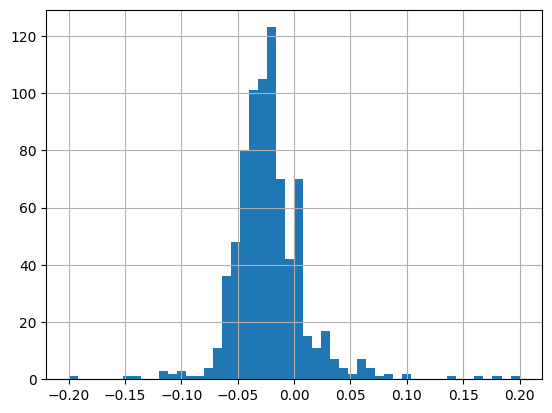

In [43]:
df_23['xRV/BF'].hist(bins=50)

<AxesSubplot: >

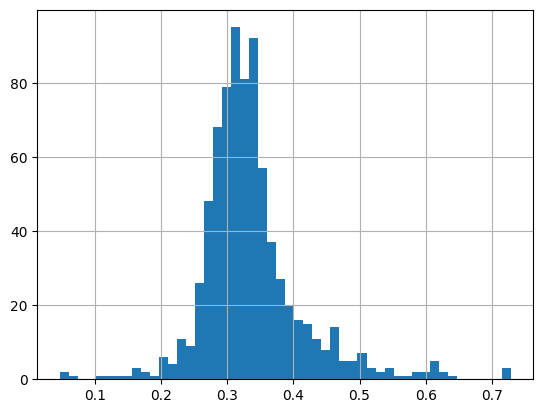

In [44]:
xera['estimated_woba_using_speedangle'].hist(bins=50)

In [45]:
df_23.corr()

C:\Users\wampl\AppData\Local\Temp\ipykernel_6360\3497080820.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,pitcher,pred_run_value,IP,ER,ERA,GDP,BB,SO,BF,mlbID,xRV/BF,xERA+,xERA
pitcher,1.000000,0.113931,-0.145062,-0.137668,0.008997,-0.113648,-0.109252,-0.124449,-0.144613,1.000000,0.002236,0.024808,0.020385
pred_run_value,0.113931,1.000000,-0.876138,-0.724368,0.208353,-0.645667,-0.677826,-0.947807,-0.857166,0.113931,0.474094,-0.076889,0.334925
IP,-0.145062,-0.876138,1.000000,0.917703,-0.215592,0.837140,0.877341,0.958532,0.997697,-0.145062,-0.310853,-0.067263,-0.288013
ER,-0.137668,-0.724368,0.917703,1.000000,-0.110072,0.760932,0.851400,0.843958,0.936416,-0.137668,-0.198063,-0.119204,-0.165410
ERA,0.008997,0.208353,-0.215592,-0.110072,1.000000,-0.182185,-0.188339,-0.221029,-0.205566,0.008997,0.381915,0.155204,0.527250
GDP,-0.113648,-0.645667,0.837140,0.760932,-0.182185,1.000000,0.749669,0.751266,0.835156,-0.113648,-0.187075,-0.098962,-0.214451
BB,-0.109252,-0.677826,0.877341,0.851400,-0.188339,0.749669,1.000000,0.865188,0.893681,-0.109252,-0.193185,-0.112584,-0.239869
SO,-0.124449,-0.947807,0.958532,0.843958,-0.221029,0.751266,0.865188,1.000000,0.952227,-0.124449,-0.390860,-0.003415,-0.326048
BF,-0.144613,-0.857166,0.997697,0.936416,-0.205566,0.835156,0.893681,0.952227,1.000000,-0.144613,-0.293280,-0.078868,-0.273779
mlbID,1.000000,0.113931,-0.145062,-0.137668,0.008997,-0.113648,-0.109252,-0.124449,-0.144613,1.000000,0.002236,0.024808,0.020385


c:\Users\wampl\anaconda3\envs\datasci\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



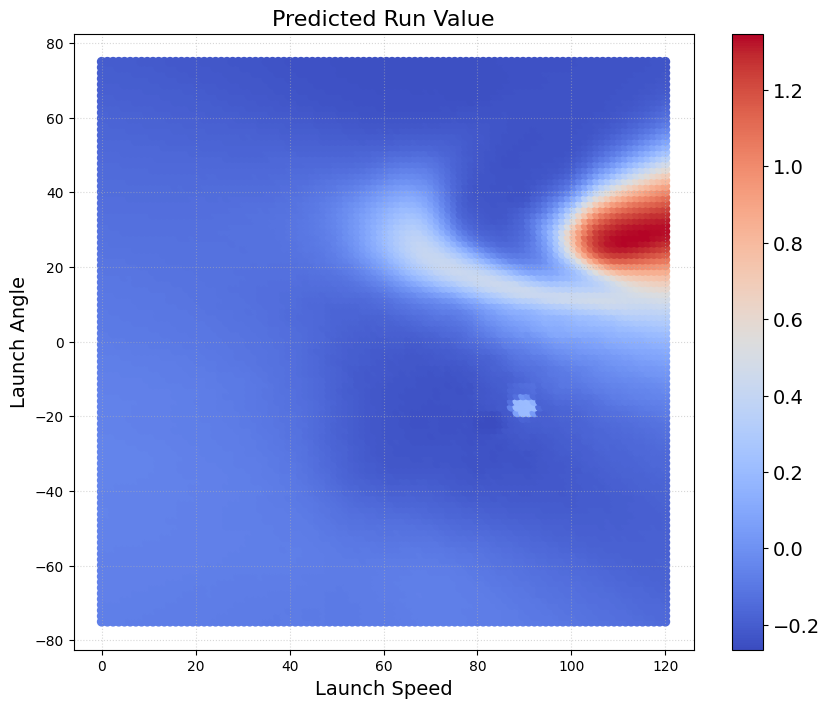

In [82]:
from sklearn.preprocessing import StandardScaler
knn_rv = joblib.load('knn_rv.joblib')
launch_speeds = np.linspace(0, 120, 100)
launch_angles = np.linspace(-75, 75, 100)
ls, la = np.meshgrid(launch_speeds, launch_angles)
X_pred = np.c_[ls.ravel(), la.ravel()]
y_pred = knn_rv.predict(X_pred)

del knn_rv

# Use StandardScaler to scale predicted_mean_run_value
scaler = StandardScaler()
y_pred_scaled = scaler.fit_transform(y_pred.reshape(-1, 1))

df_pred = pd.DataFrame({
    'launch_speed': ls.ravel(),
    'launch_angle': la.ravel(),
    'pred_run_value_scaled': y_pred_scaled.ravel(),
    'pred_run_value': y_pred.ravel()
})

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pred['launch_speed'], df_pred['launch_angle'], c=df_pred['pred_run_value'], cmap='coolwarm')

# Add a colorbar
cbar = plt.colorbar(scatter, label='')
cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick size

# Add grid
plt.grid(True, linestyle=':', alpha=0.5)

# Set the title and labels, increase their size
plt.title('Predicted Run Value', fontsize=16)
plt.xlabel('Launch Speed', fontsize=14)
plt.ylabel('Launch Angle', fontsize=14)

# Show the plot
plt.show()


c:\Users\wampl\anaconda3\envs\datasci\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



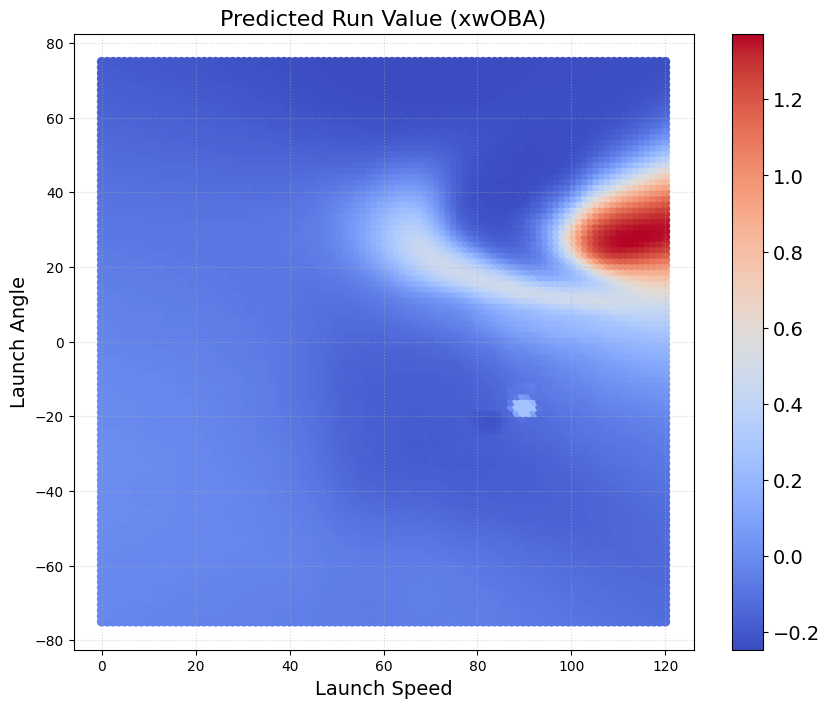

In [83]:
from sklearn.preprocessing import StandardScaler
df_all_bip = df_all.dropna(subset=['launch_speed', 'launch_angle', 'woba_value'])

X = df_all_bip[['launch_speed', 'launch_angle']]
y_woba = df_all_bip['woba_value']

X_train, X_test, y_train, y_test = train_test_split(X, y_woba, test_size=0.2, random_state=42)

# knn_woba = KNeighborsRegressor(n_neighbors=5000, n_jobs=-1)
# knn_woba.fit(X_train, y_train)

# joblib.dump(knn_woba, 'knn_woba.joblib')

knn_woba = joblib.load('knn_woba.joblib')
y_pred_woba = knn_woba.predict(X_pred)

del knn_woba

# Use StandardScaler to scale pred_woba_value
scaler = StandardScaler()
y_pred_woba_scaled = scaler.fit_transform(y_pred_woba.reshape(-1, 1))

df_pred['pred_woba_converted_rv'] = (y_pred_woba-0.3)/1.208 # convert woba to rv using value of out and wOBA scale
df_pred['pred_woba_value_scaled'] = y_pred_woba_scaled

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pred['launch_speed'], df_pred['launch_angle'], c=df_pred['pred_woba_converted_rv'], cmap='coolwarm')

# Add a colorbar
cbar = plt.colorbar(scatter, label='')
cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick size

# Add grid
plt.grid(True, linestyle=':', alpha=0.5)

# Set the title and labels, increase their size
plt.title('Predicted Run Value (xwOBA)', fontsize=16)
plt.xlabel('Launch Speed', fontsize=14)
plt.ylabel('Launch Angle', fontsize=14)

# Show the plot
plt.show()



In [84]:
pd.set_option('display.max_colwidth', None)

df_all.loc[df_all['launch_speed'].isin(range(85,95)) & df_all['launch_angle'].isin(range(-20,-10)), ['game_year', 'woba_value', 'des', 'launch_speed', 'launch_angle']].nlargest(20, 'woba_value')

,game_year,woba_value,des,launch_speed,launch_angle
4093596,2021,1.60,Jarrod Dyson triples (1) on a ground ball to right fielder Josh Palacios.,94.0,-15.0
111391,2015,1.25,"Eugenio Suarez doubles (9) on a ground ball to shortstop Nick Ahmed, deflected by third baseman Jake Lamb.",87.0,-16.0
162172,2015,1.25,Marlon Byrd doubles (14) on a line drive to left fielder Starling Marte.,85.0,-11.0
632060,2016,1.25,Matt Joyce doubles (6) on a ground ball to right fielder Jason Heyward. David Freese to 3rd.,91.0,-15.0
660058,2016,1.25,Troy Tulowitzki doubles (8) on a ground ball to left fielder Melky Cabrera. Michael Saunders scores.,91.0,-16.0
954405,2016,1.25,Chris Owings doubles (21) on a ground ball to left fielder Angel Pagan.,85.0,-15.0
1067666,2017,1.25,Jarrod Dyson doubles (2) on a ground ball to right fielder Josh Reddick.,94.0,-12.0
1080140,2017,1.25,Elvis Andrus doubles (4) on a ground ball to left fielder Cameron Maybin.,89.0,-14.0
1241892,2017,1.25,"Rio Ruiz hits a ground-rule double (1) on a ground ball down the right-field line, on fan interference.",91.0,-11.0
1439032,2017,1.25,Ian Desmond doubles (7) on a ground ball to left fielder Michael Conforto. Mark Reynolds to 3rd.,93.0,-17.0


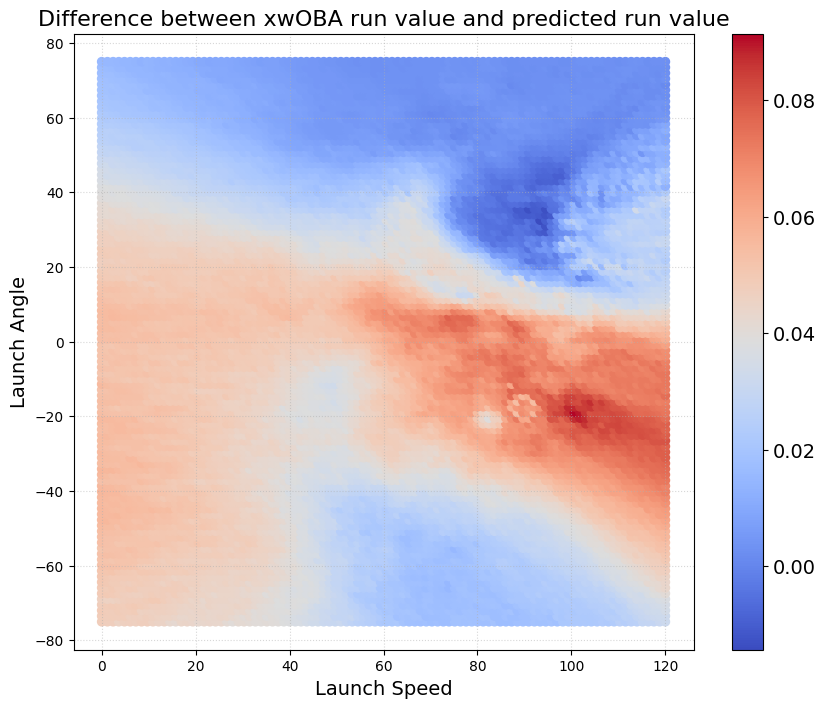

In [85]:
# Create the scatter plot
plt.figure(figsize=(10, 8))
df_pred['pred_diff'] = df_pred['pred_woba_converted_rv'] - df_pred['pred_run_value']
scatter = plt.scatter(df_pred['launch_speed'], df_pred['launch_angle'], c=df_pred['pred_diff'], cmap='coolwarm')

# Add a colorbar
cbar = plt.colorbar(scatter, label='')
cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick size

# Add grid
plt.grid(True, linestyle=':', alpha=0.5)

# Set the title and labels, increase their size
plt.title('Difference between xwOBA run value and predicted run value', fontsize=16)
plt.xlabel('Launch Speed', fontsize=14)
plt.ylabel('Launch Angle', fontsize=14)

# Show the plot
plt.show()

In [86]:
from sklearn.neighbors import KNeighborsClassifier
df_all_bip = df_all.dropna(subset=['launch_speed', 'launch_angle', 'pitch_name'])

X = df_all_bip[['launch_speed', 'launch_angle']]
y = df_all_bip['pitch_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5000, n_jobs=-1)
knn.fit(X_train, y_train)

launch_speeds = np.linspace(0, 120, 100)
launch_angles = np.linspace(-75, 75, 100)
ls, la = np.meshgrid(launch_speeds, launch_angles)
X_pred = np.c_[ls.ravel(), la.ravel()]
y_pred = knn.predict(X_pred)

df_pred['predicted_pitch_type'] = y_pred


c:\Users\wampl\anaconda3\envs\datasci\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



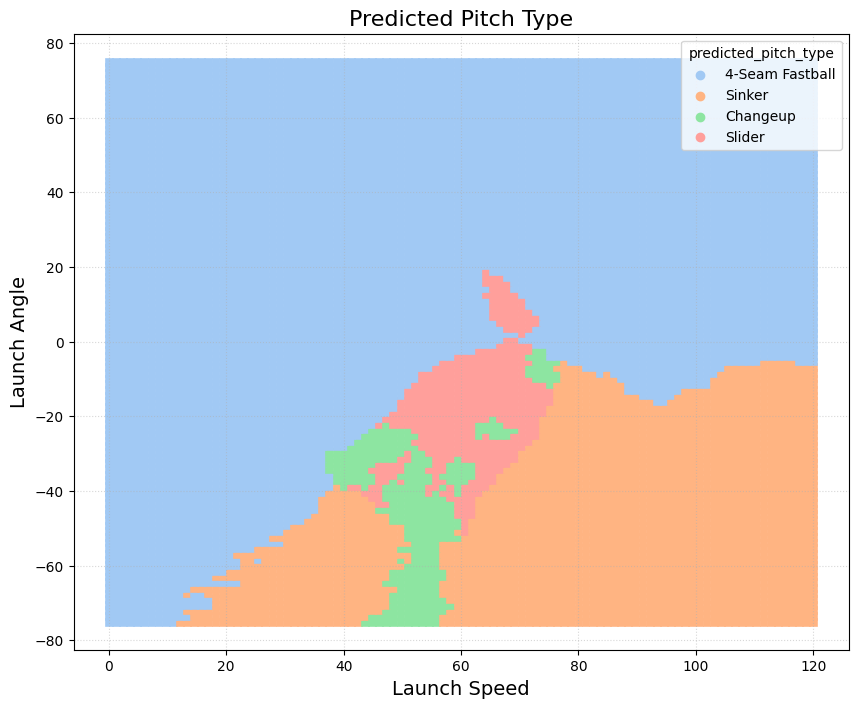

In [87]:
plt.figure(figsize=(10, 8))

scatter = sns.scatterplot(x=df_pred['launch_speed'], y=df_pred['launch_angle'], marker='s', s=32, edgecolor=None, hue=df_pred['predicted_pitch_type'], palette='pastel')
# Add grid
plt.grid(True, linestyle=':', alpha=0.5)

# Set the title and labels, increase their size
plt.title('Predicted Pitch Type', fontsize=16)
plt.xlabel('Launch Speed', fontsize=14)
plt.ylabel('Launch Angle', fontsize=14)

# Show the plot
plt.show()

In [88]:
df_all_bip.shape

(1386435, 108)

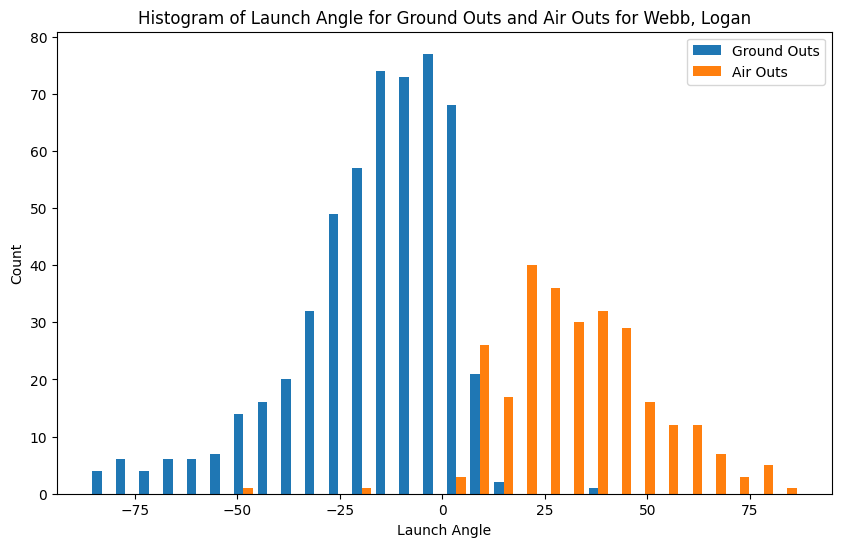

In [89]:

webb_ground_outs_launch_angle = df_all[(df_all['new_events'] == 'ground_out') & (df_all['player_name'] == 'Webb, Logan')]['launch_angle']
webb_air_outs_launch_angle = df_all[(df_all['new_events'] == 'air_out') & (df_all['player_name'] == 'Webb, Logan')]['launch_angle']

plt.figure(figsize=(10, 6))
plt.hist([webb_ground_outs_launch_angle, webb_air_outs_launch_angle], bins=30, label=['Ground Outs', 'Air Outs'])
plt.xlabel('Launch Angle')
plt.ylabel('Count')
plt.legend()
plt.title('Histogram of Launch Angle for Ground Outs and Air Outs for Webb, Logan')
plt.show()






<AxesSubplot: >

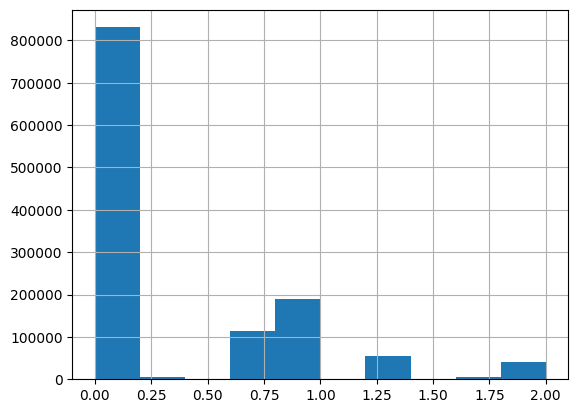

In [90]:
df_all['woba_value'].hist()

(array([1334., 1773., 1866., 2404., 1305.,  187.,  147.,  129.,  118.,
         105.,   77.,   87.,   87.,   87.,   18.,   18.,   17.,   15.,
          17.,   10.,   16.,   11.,   11.,   17.,   12.,   17.,   20.,
          17.,   26.,   52.]),
 array([-0.88679971, -0.65114824, -0.41549677, -0.1798453 ,  0.05580617,
         0.29145764,  0.52710912,  0.76276059,  0.99841206,  1.23406353,
         1.469715  ,  1.70536647,  1.94101794,  2.17666941,  2.41232088,
         2.64797235,  2.88362382,  3.11927529,  3.35492677,  3.59057824,
         3.82622971,  4.06188118,  4.29753265,  4.53318412,  4.76883559,
         5.00448706,  5.24013853,  5.47579   ,  5.71144147,  5.94709294,
         6.18274442]),
 <BarContainer object of 30 artists>)

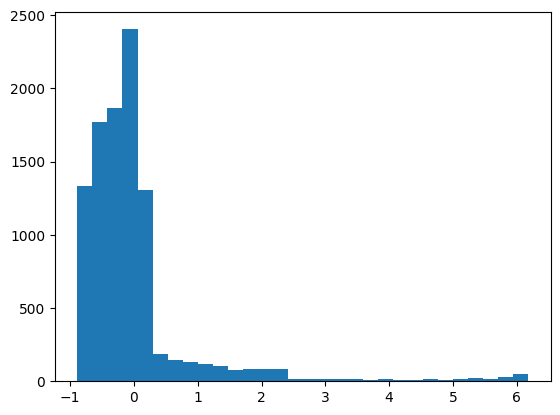

In [91]:
plt.hist(y_pred_woba_scaled, bins=30)

(array([1781., 1950., 2176., 2649.,  213.,  164.,  136.,  121.,  112.,
          84.,   78.,   88.,  109.,   43.,   21.,   17.,   17.,   15.,
          15.,   12.,   16.,    8.,   13.,   18.,   12.,   18.,   18.,
          18.,   27.,   51.]),
 array([-0.81810516, -0.58237546, -0.34664576, -0.11091606,  0.12481364,
         0.36054334,  0.59627304,  0.83200274,  1.06773244,  1.30346214,
         1.53919185,  1.77492155,  2.01065125,  2.24638095,  2.48211065,
         2.71784035,  2.95357005,  3.18929975,  3.42502945,  3.66075916,
         3.89648886,  4.13221856,  4.36794826,  4.60367796,  4.83940766,
         5.07513736,  5.31086706,  5.54659676,  5.78232647,  6.01805617,
         6.25378587]),
 <BarContainer object of 30 artists>)

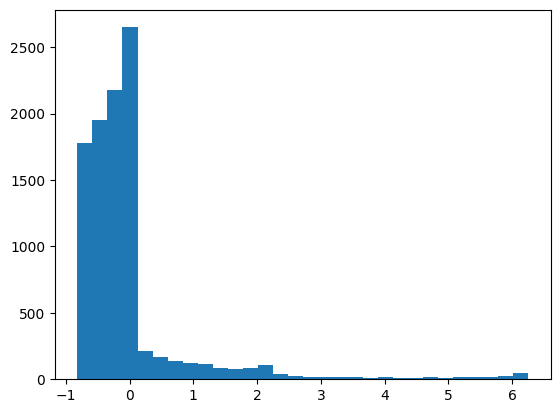

In [92]:
plt.hist(y_pred_scaled, bins=30)